In [15]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %matplotlib inline
# mpl.pyplot.style.use('default')
# mpl.pyplot.close('all')

# font, rcnew = plot_utils.matplotlib_default_config()
# mpl.rc('font', **font)
# mpl.pyplot.rcParams.update(rcnew)
# mpl.pyplot.style.use('tableau-colorblind10')
# %config InlineBackend.figure_format = 'retina'

# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12

In [3]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
param_names_key_rp = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
param_names_bias = ['b2', 'bs2', 'bl']
param_names_bias_rp = ['sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_noise_rp = ['An_homog', 'sigma8_cold_x_An_b1', 'sigma8_cold_sq_x_An_b2', 'sigma8_cold_sq_x_An_bs2', 'sigma8_cold_x_An_bl']

# test on single

In [29]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib{tag_params}'
#dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [30]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [31]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [34]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
print(params_df)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

None


AttributeError: 'NoneType' object has no attribute 'loc'

In [35]:
matter_density_field = bias_terms_eul[1]
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field, cosmo, box_size, n_grid_orig)

Computing pgm, using n_grid =  128


2026-01-28 07:39:31,361 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-28 07:39:31,489 bacco.statistics :  ...done in 0.128 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.004623 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.053673 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


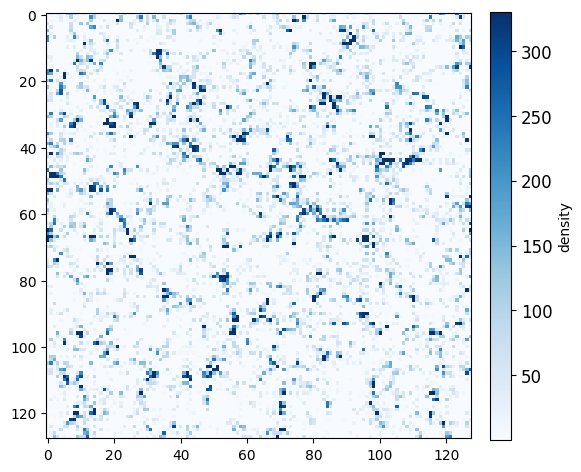

In [36]:
plotter.plot_field(matter_density_field, overdensity=False)

In [9]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-28 03:19:48,775 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-28 03:19:48,819 bacco.statistics :  ...done in 0.0435 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002312 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022946 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_1048905/847835007.py:15: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


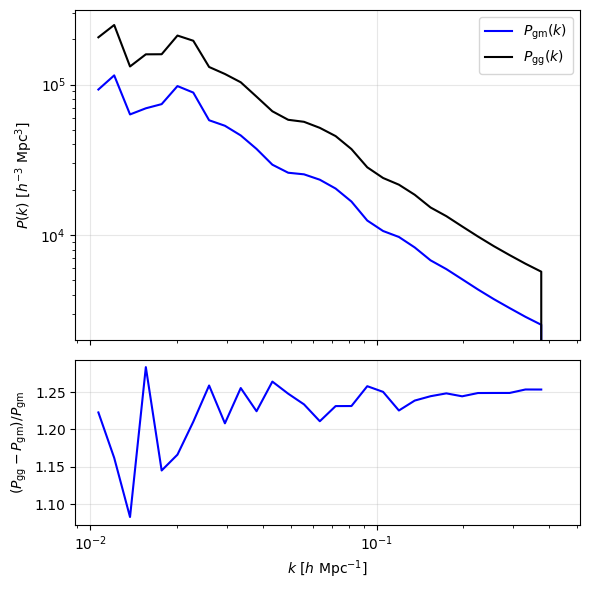

In [10]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# shame

In [11]:
from process_catalogs import round_to_nearest_even

In [53]:
data_mode = 'shame'
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)
box_size_mock = 1024.0
box_size_muchisimocks = 1000.0
n_grid_orig = 512
n_grid = 128
n_grid_orig_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_orig))
n_grid_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid))
print(n_grid_orig_mock)

524


In [8]:
tag_mock = '_nbar0.00022'
fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
tracer_field0 = np.load(fn_cat0_mesh)
print(tracer_field0.shape)

(132, 132, 132)


In [ ]:
#dens_field0 = dens_field0_kcut_deconvolved
fn_dens0_mesh = f'../data/data_{data_mode}/dens_mesh_phase0.npy'
dens_field0 = np.load(fn_dens0_mesh)
print(dens_field0.shape)

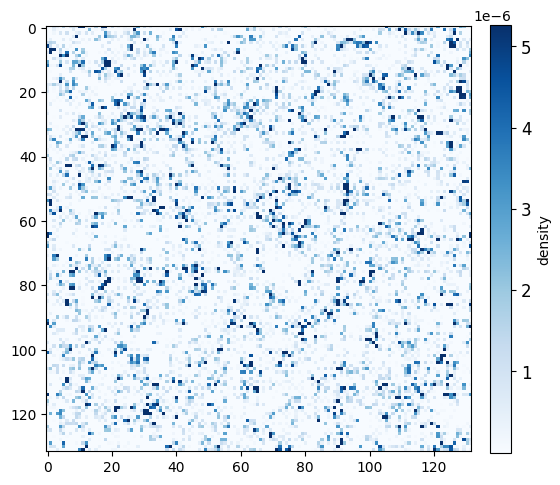

In [37]:
plotter.plot_field(tracer_field0, overdensity=False)

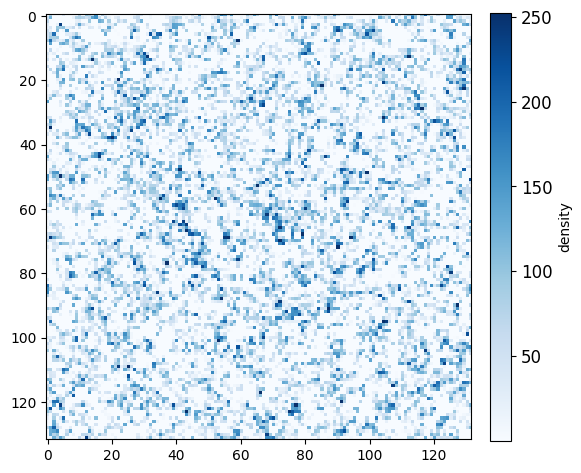

In [ ]:
plotter.plot_field(dens_field0, overdensity=False)

In [67]:
pgm_obj_shame = cs.compute_pgm(tracer_field0, dens_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pgm, using n_grid =  132


2026-01-28 08:14:53,103 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:14:53,219 bacco.statistics :  ...done in 0.115 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) -3.34603e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012225 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.049103 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


In [68]:
pk_obj_shame = cs.compute_pk(tracer_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-28 08:14:55,211 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:14:55,306 bacco.statistics :  ...done in 0.0944 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) -6.16393e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007800 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.054090 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000141 secs
bacco.power : Deallocating arrays


In [69]:
pmm_obj_shame = cs.compute_pk(dens_field0/n_grid_orig_mock**3, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-28 08:14:57,541 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:14:57,633 bacco.statistics :  ...done in 0.0917 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -3.34603e-10 (grid1) -3.34603e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007459 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.046463 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000143 secs
bacco.power : Deallocating arrays


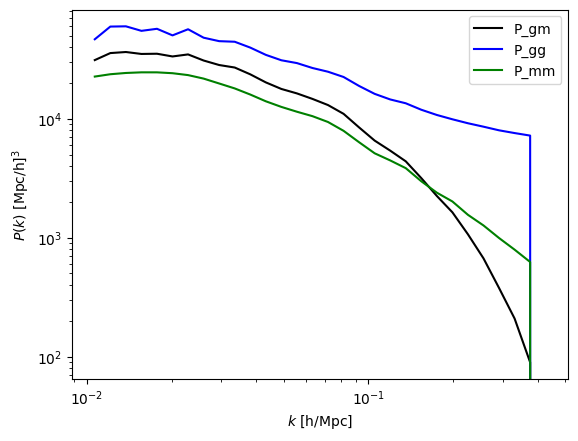

In [70]:
plt.plot(pgm_obj_shame['k'], pgm_obj_shame['pk'], label='P_gm', color='black')
plt.plot(pk_obj_shame['k'], pk_obj_shame['pk'], label=f'P_gg', color='blue')
plt.plot(pmm_obj_shame['k'], pmm_obj_shame['pk'], label='P_mm', color='green')
plt.legend()
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Load and plot

In [11]:
data_mode = 'muchisimocks'
statistics = ['pk', 'pgm']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_unit_p5_n10000'
# tag_Anoise = '_Anmult_p5_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_noise = None
tag_Anoise = None
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
if tag_noise is None:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
else:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_noise + tag_Anoise + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000


Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Found 1000 diff cosmo pgms in /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loaded pgm data with shape (1000, 30)
fn_mask: ../data/masks/mask_pgm_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Saving mask to ../data/masks/mask_pgm_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Mask masks out 1 Pgm bins
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
(1000, 29)


In [12]:
theta, param_names = data_loader.param_dfs_to_theta(idxs_params, params_df, biasparams_df, Anoise_df=Anoise_df)

In [13]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_pgm = k_arr[statistics.index('pgm')]
y_pgm = y_arr[statistics.index('pgm')]

# k_bispec = k_arr[statistics.index('bispec')]
# y_bispec = y_arr[statistics.index('bispec')]


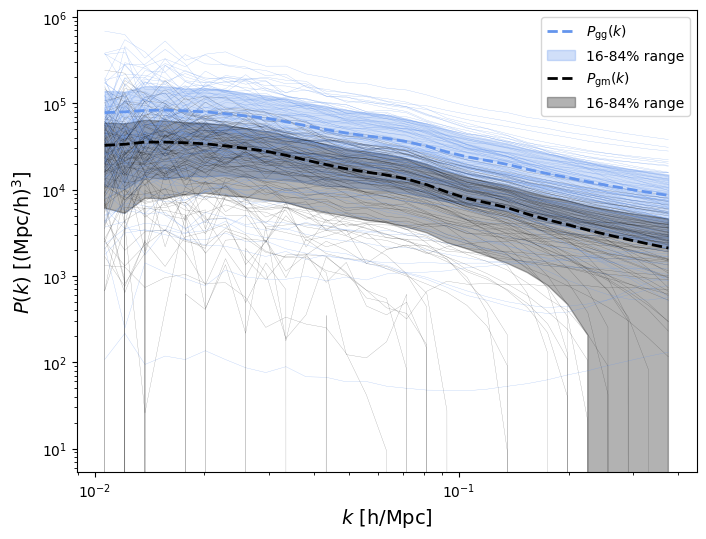

In [14]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    label = None
    plt.plot(k_pk, y_pk[i], color='cornflowerblue', alpha=0.6, lw=0.2, label=label)
    plt.plot(k_pgm, y_pgm[i], color='black', alpha=0.4, lw=0.2, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cornflowerblue', lw=2, ls='--', label=r'$P_{\rm gg}(k)$')
plt.fill_between(k_pk, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

mean = np.mean(y_pgm, axis=0)
p16 = np.percentile(y_pgm, 16, axis=0)
p84 = np.percentile(y_pgm, 84, axis=0)
plt.plot(k_pgm, mean, color='black', lw=2, ls='--', label=r'$P_{\rm gm}(k)$')
plt.fill_between(k_pgm, p16, p84, color='black', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10)